In [1]:
import numpy as np
np.set_printoptions(suppress=True, precision=4)
import pandas as pd
from matplotlib import pyplot as plt
#%matplotlib widget

import os

In [2]:
from motorica.emg8.pipeline import read_emg8
from motorica.emg8.constants import *

from motorica.emg8.markers import BaseMarker, FullMarker

# Data

In [3]:
DATA_DIR = 'data/plt_mb/all'
montages = sorted(filter(lambda f: f.endswith('.emg8'), os.listdir(DATA_DIR)))
montages

['2024-12-12_20-23-37.emg8',
 '2024-12-12_20-29-14.emg8',
 '2024-12-12_20-34-24.emg8',
 '2024-12-13_19-48-48.emg8',
 '2024-12-13_19-53-58.emg8',
 '2024-12-13_20-00-16.emg8',
 '2024-12-15_14-56-56.emg8',
 '2024-12-15_15-02-08.emg8',
 '2024-12-15_15-06-56.emg8']

In [4]:
# palm_file = './data/new/2024-12-09_11-22-43.emg8'
# gestures = pd.read_csv(palm_file, sep= ' ', on_bad_lines='warn')
# gestures = gestures.query('id != -1')

# palm_file = '2024-12-02_14-03-05.emg8'
palm_file = montages[-1]
marker = FullMarker()
X_train, X_test, y_train, y_test, groups, gestures = read_emg8(
    palm_file, 
    dir=DATA_DIR,
    marker=marker,
    n_holdout_groups=1
)

display(gestures.head())

# GESTURES = gestures['state'].unique()
# # renumerate gestures from zero
# gestures['id'] = gestures['state'].replace({gesture: i for i, gesture in enumerate(GESTURES)})

GESTURES = gestures['state'].unique()
display(gestures[['id', 'state']].drop_duplicates())

# В качестве last_train_idx возьмем последнее измерение предпоследнего цикла
last_train_idx = gestures['group'].drop_duplicates().index[-1] - 1
print('last_train_idx:', last_train_idx)

,ts,td,omg0,omg1,omg2,omg3,omg4,omg5,omg6,omg7,...,prb7,argmax,denoize,prot,state,id,now,act_label,sample,group
125,852816.0,40.0,14820599.0,10925019.0,6703861.0,14652430.0,11074965.0,7373630.0,9031503.0,13277765.0,...,0.12,0.0,0.0,1,Neutral,0,5.00,0,0,0.0
126,852856.0,40.0,14826187.0,10907466.0,6692306.0,14633235.0,11072368.0,7363681.0,9031247.0,13281660.0,...,0.12,0.0,0.0,1,Neutral,0,5.04,0,0,0.0
127,852896.0,40.0,14817878.0,10897118.0,6683532.0,14624512.0,11059461.0,7349871.0,9030441.0,13278434.0,...,0.12,0.0,0.0,1,Neutral,0,5.08,0,0,0.0
128,852936.0,40.0,14816663.0,10914261.0,6683015.0,14627359.0,11066505.0,7359309.0,9029148.0,13286099.0,...,0.12,0.0,0.0,1,Neutral,0,5.12,0,0,0.0
129,852976.0,40.0,14817458.0,10919599.0,6680369.0,14636907.0,11063725.0,7360648.0,9023783.0,13278577.0,...,0.12,0.0,0.0,1,Neutral,0,5.16,0,0,0.0


,id,state
125,0,Neutral
225,1,ThumbFingers
375,2,Close
525,3,Open
675,4,Pinch
825,5,Indication
975,6,Wrist_Flex
1125,7,Wrist_Extend


last_train_idx: 4488


In [5]:
# N_OMG_CH = 16

# OMG_CH = [f'omg{i}' for i in range(N_OMG_CH)]

print(f"OMG_CH: {list(OMG_CH)}")

OMG_CH: ['omg0', 'omg1', 'omg2', 'omg3', 'omg4', 'omg5', 'omg6', 'omg7', 'omg8', 'omg9', 'omg10', 'omg11', 'omg12', 'omg13', 'omg14', 'omg15']


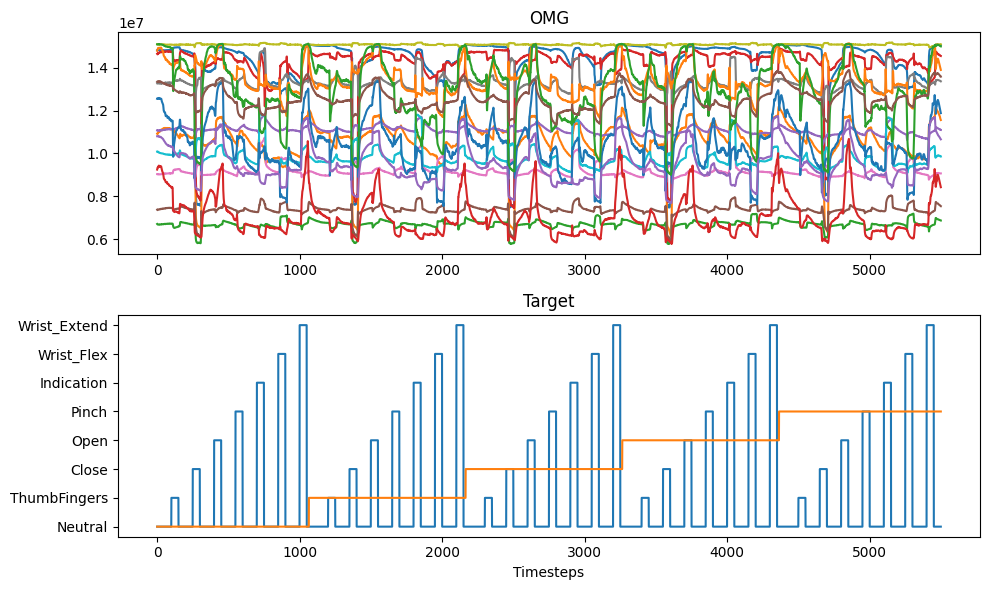

In [6]:
fig, axx = plt.subplots(2, 1, figsize=(10, 6))
plt.sca(axx[0])
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')

plt.sca(axx[1])
plt.plot(gestures['id'].values)
plt.title('Target')
plt.plot(gestures['group'].values)
plt.title('Target')
plt.yticks(np.arange(len(GESTURES)), GESTURES)

plt.xlabel('Timesteps')
plt.tight_layout()

# Dataset forming

In [7]:
# last_train_idx = 3300
# X_train = gestures[OMG_CH].values[:last_train_idx]
# y_train = gestures['id'].values[:last_train_idx]

# X_test = gestures[OMG_CH].values[last_train_idx:]
# y_test = gestures['id'].values[last_train_idx:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4364, 16) (4364,)
(1136, 16) (1136,)


# Modeling

In [8]:
# from sklearn.linear_model import LogisticRegression

# model = LogisticRegression()

from motorica.emg8.pipeline import create_logreg_pipeline

model, _ = create_logreg_pipeline()

model.fit(X=X_train, y=y_train)

Pipeline(steps=[('fix_1dim_sample', FixOneDimSample()),
                ('noise_reduct', NoiseReduction()),
                ('diff_with_prev',
                 DiffWithPrev(avg='median', first_n=16, oper='replace')),
                ('cut_outliers', CutOutliers()),
                ('gradients', Gradients(n_lags=7)), ('scaler', MinMaxScaler()),
                ('model', PostprocWrapper(n_lags=9))])

## Prediction

In [9]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

y_train[y_train < 0] = 0
y_train %= 10
y_test[y_test < 0] = 0
y_test %= 10

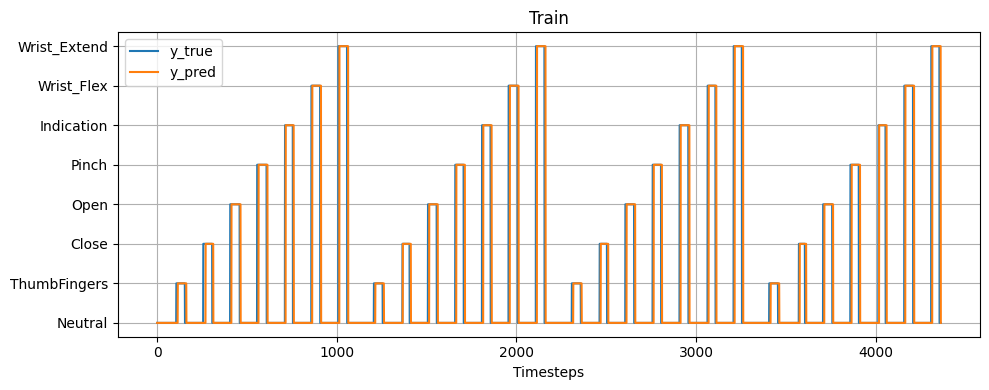

In [10]:
fig = plt.figure(figsize=(10, 4))
plt.plot(y_train,  c='C0', label='y_true')
plt.plot(y_pred_train, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Train')
plt.tight_layout()

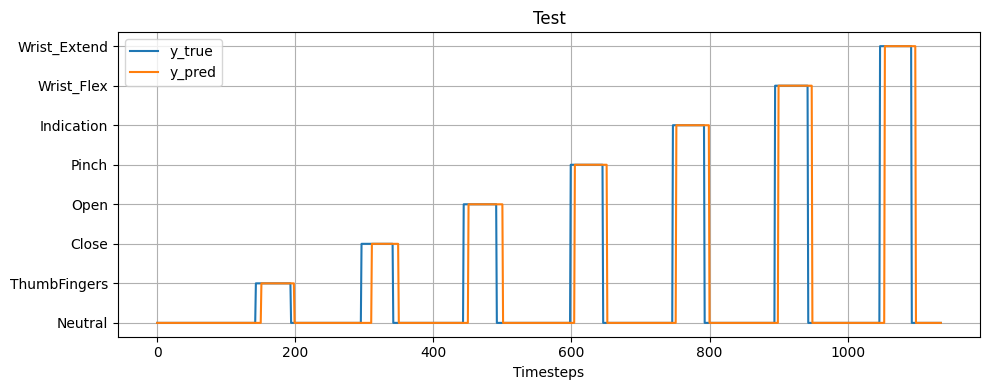

In [11]:
fig = plt.figure(figsize=(10, 4))
plt.plot(y_test,  c='C0', label='y_true')
plt.plot(y_pred_test, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Test')
plt.tight_layout()

## Metrics

In [12]:
from sklearn.metrics import classification_report
from motorica.emg8.pipeline import shift_target, get_total_shift

shift = get_total_shift(model)

y_train_shift = shift_target(y_train, shift)
y_test_shift = shift_target(y_test, shift)
print("Train data:")
print(classification_report(y_train_shift, y_pred_train, target_names=GESTURES))
print("Test data:")
print(classification_report(y_test_shift, y_pred_test, target_names=GESTURES))

Train data:
              precision    recall  f1-score   support

     Neutral       0.97      0.98      0.97      3045
ThumbFingers       0.98      0.95      0.97       196
       Close       0.92      0.92      0.92       165
        Open       0.96      0.93      0.94       202
       Pinch       0.95      0.94      0.95       194
  Indication       0.92      0.93      0.92       181
  Wrist_Flex       0.94      0.92      0.93       193
Wrist_Extend       0.94      0.95      0.94       188

    accuracy                           0.96      4364
   macro avg       0.95      0.94      0.94      4364
weighted avg       0.96      0.96      0.96      4364

Test data:
              precision    recall  f1-score   support

     Neutral       0.97      0.98      0.98       804
ThumbFingers       0.98      0.92      0.95        51
       Close       1.00      0.85      0.92        46
        Open       0.96      1.00      0.98        48
       Pinch       0.94      0.94      0.94        47
 

# Real-time inference

In [13]:
import time
#import serial
from copy import deepcopy

## Inference Utils: Put your code here

In [14]:
def preprocessing(x):
    return x

def inference(x):
    return model.predict(x)

def postprocessing(x, prev):
    return x

## Inference

### Offline (dataset)

In [15]:
df_sim = gestures.loc[last_train_idx + 1:]
print(df_sim.shape)

(1136, 46)


In [16]:
TIMEOUT = 0.033
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
y_dct = {
    'omg_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        td_ts, omg_sample, _ = np.array_split(sample, [2, 2 + N_OMG_CH])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)#.astype(float))
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    # NO COMMANDS forming IN SIMULATION
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        # sanity check: Sizes of SAMPLE=65, OMG=16
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}', end='             \r')
    
    ts_diff = time.time() - ts_start
    # assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

In [17]:
for key, val in y_dct.items():
    #print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (1136, 16)
sample_preprocessed.shape = (1136, 16)
y_predicted.shape = (1136, 1)
y_postprocessed.shape = (1136, 1)


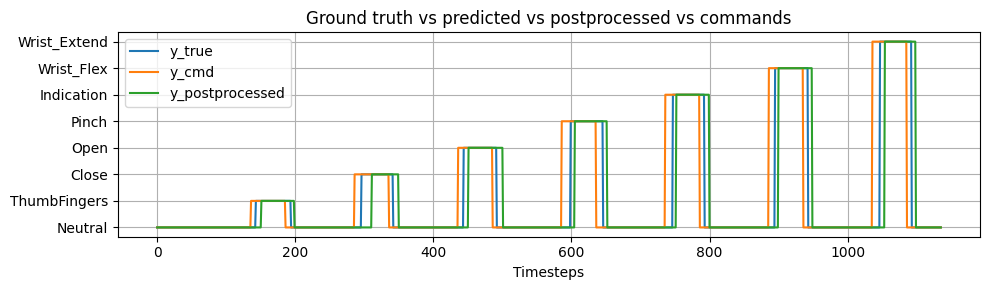

In [18]:
fig = plt.figure(figsize=(10, 3))

plt.plot(y_test, c='C0', label='y_true')
plt.plot(gestures.loc[last_train_idx + 1:, 'id'].reset_index(drop=True), c='C1', label='y_cmd')
#plt.plot(y_dct['y_predicted'].argmax(axis=1), c='C1', label='y_predicted')
#plt.plot(y_dct['y_postprocessed'].argmax(axis=1), c='C2', label='y_postprocessed')
#plt.plot(y_dct['y_predicted'], c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [19]:
print(classification_report(y_test, y_dct['y_postprocessed'], target_names=GESTURES))

              precision    recall  f1-score   support

     Neutral       0.93      0.94      0.94       804
ThumbFingers       0.90      0.84      0.87        51
       Close       0.79      0.67      0.73        46
        Open       0.82      0.85      0.84        48
       Pinch       0.87      0.87      0.87        47
  Indication       0.85      0.89      0.87        46
  Wrist_Flex       0.88      0.90      0.89        48
Wrist_Extend       0.87      0.85      0.86        46

    accuracy                           0.91      1136
   macro avg       0.86      0.85      0.86      1136
weighted avg       0.91      0.91      0.91      1136



### Online

#### Virtual hand

In [22]:
import VirtualPhantom
vp = VirtualPhantom.VirtualPhantomClient('localhost', 1755)

ModuleNotFoundError: No module named 'VirtualPhantom'

In [ ]:
GESTURES

In [ ]:
# Bindings for virtual hand
def commands(x):
    cmd = vp.neutral_state.copy()
    # for this mapping look at GESTURES
    if x == 0: # Pilot Neutral
        pass # Do nothing
    elif x == 1: # Pilot thumb_fingers
        # Virtual Hand thumb_fingers
        cmd.update({'thumb_flex': 1, 'index_extend': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
    elif x == 2: # Pilot close_state
        # Virtual Hand close_state
        cmd.update({'thumb_flex': 1, 'index_flex': 1, 'middle_flex': 1, 'ring_flex': 1, 'pinky_flex': 1})
    elif x == 3: # Pilot open_state
        cmd.update({'thumb_extend': 1, 'index_extend': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
    elif x == 4: # Pilot pinch_state
        cmd.update({'thumb_flex':1, 'index_flex': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
    elif x == 5: # Pilot indication_state
        cmd.update({ 'thumb_extend':1, 'index_extend': 1, 'middle_flex': 1, 'ring_flex': 1, 'pinky_flex': 1})
    elif x == 6: # Wrist_Flex
        cmd.update({'wrist_flex': 1})
    elif x == 7: # Wrist_Extend
        cmd.update({'wrist_extend': 1})
    else:
        pass # Do nothing
    
    return cmd

In [ ]:
!ls /dev/ttyACM* /dev/ttyUSB*

In [ ]:
ser_name = '/dev/ttyACM0'
try:
    ser.close()
except:
    pass
ser = serial.Serial(ser_name, baudrate=115200, timeout=60);

ser.write('PT1\r\n'.encode())
time.sleep(0.1)
ser.write('Pt1\r\n'.encode())
time.sleep(0.1)
ser.flush()
time.sleep(0.1)

def parseline():
    line = ser.readline().decode().replace('\n', '')
    data = np.array(list(filter(len, np.array(line.split(" "))))).astype(float)
    return data

In [ ]:
TIMEOUT = 0.033
DEBUG = True

while(ser.in_waiting>50):
    ser.readline()
    time.sleep(0.005)
ser.readline()
    
t_start = time.time()
prev_idx = -1

y_previous = None
while True:    
    
    # [Data reading]
    t_rel = time.time() - t_start
    
    try: 
        data = parseline()
        data_line = ' '.join(data.astype(str))
        data_line += f' {-1} {"Inference"} {-1} {t_rel:.2f}'
    except Exception as e:
        raise(e)
        data_line = ' '.join(['-1']*n_cols)
        data_line += f' {-1} {"Error"} {-1} {t_rel:.2f}'

    td_ts, omg_sample, _ = np.array_split(data, [2, 2 + N_OMG_CH])        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed   = preprocessing(omg_sample.astype(float))
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted           = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed       = postprocessing(y_predicted, y_previous)
    y_postprocessed_label = y_postprocessed.argmax()
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed_label)
    # [/Commands composition]
    
    # [Commands sending]
    prot_idx = deepcopy(y_postprocessed_label)
    if (prot_idx != prev_idx):
        vp.send_cmd(**y_commands)
        prev_idx = deepcopy(prot_idx)
    # [/Commands sending]
    
    # [Data logging]
    # [/Data logging]

    y_previous = y_postprocessed.copy()
    time.sleep(0.001)
    t_rel = time.time() - t_start
    
    if DEBUG:
        # sanity check: Sizes of SAMPLE=65, OMG=16
        # print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}', end='             \r')
        # print(GESTURES[y_postprocessed_label], sample_preprocessed.tolist(), end='             \r')
        print(GESTURES[y_postprocessed_label], y_predicted, end='             \r')
    
    # assert(t_rel<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'